# Georeferenced Raster Data Deconstructed

In this notebook you will learn about georeferenced raster data: the information required to georeference this data; and the tools available to work with it in python.  Although I use python here, similar tools are available in R and Matlab.  What you learn in this notebook can also help understand raster data in GIS.

## What does Georeferenced mean?
Georeferenced data is data that is tied to a location on Earth.  This location is often somewhere in the Earth's surface.  But it could be in the atmosphere, in the ocean, or beneath the land surface.

## Types of Georeferenced Data
Broadly, georeferenced data can be divided into _vector_ and _raster_ data.  **Vector** data are points, lines and polygons.  Point data could be weather stations or sampling points.  Lines can represent the flowline of a glacier.  Polygons can be used to represent areas, like the outline of a glacier.  In this notebook, we will focus on raster data.

## So what is Raster Data?
_Rasters_ are 2-dimensional arrays (grids) of equally-sized _pixels_ (grid-cells).  Each pixel has a value, and a location defined by position in the grid.  Rasters are used to represent images captured by a phone or a satellite sensor, as well as output from computer models.    

In [176]:
from itertools import chain, product

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
from pyproj import CRS
from affine import Affine

### An Example

@fig-nsidc-logo a familiar image.  It is a 2D array of pixels.  It is not georeferenced, and doesn't make a lot of sense to georeference it.  But I will use the image to demonstrate how any _raster_ can be georeferenced.

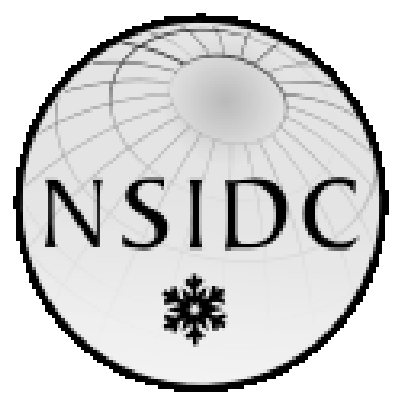

In [48]:
#| label: fig-nsidc-logo
#| fig-cap: "An example image"

image = plt.imread("../../../images/gray_diy.png")
image = image[:,:,0:3].mean(axis=2)

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(image, cmap="Greys", interpolation="none")
ax.set_axis_off()

I've read the image shown above into a 2D array called `image`.  We can find out the shape by calling the `shape` attribute of the array.

In [3]:
#| code-fold: false
#| echo: true
image.shape

(120, 120)

The shape of the image is 120 columns by 120 rows.  In row and column units, each pixel is $1 \times 1$.  We also need to know where the origin of image.  In this case, because the original image was stored as a PNG (an image format), The origin is the upper-left corner of the upper-left pixel.

The plots below demonstrates how different plotting tools treat the image.  The plot on the left is created with `matplotlib.pyplot.imshow`, which is a tool to plot images and assumes the origin is in the upper-left corner.  The plot on the right is created with `matplotlib.pyplot.pcolormesh`, which is a tool that assumes data are in cartesian coordinates with the origin at the lower-left corner.  The result is that `pcolormesh` plots the image upside down.

::: {.callout-note}
If a cartesian grid is plotted with `matplotlib.pyplot.imshow` or a tool designed to plot images, that grid would be plotted upside down, unless the plotting tool is given the location of the origin.
:::

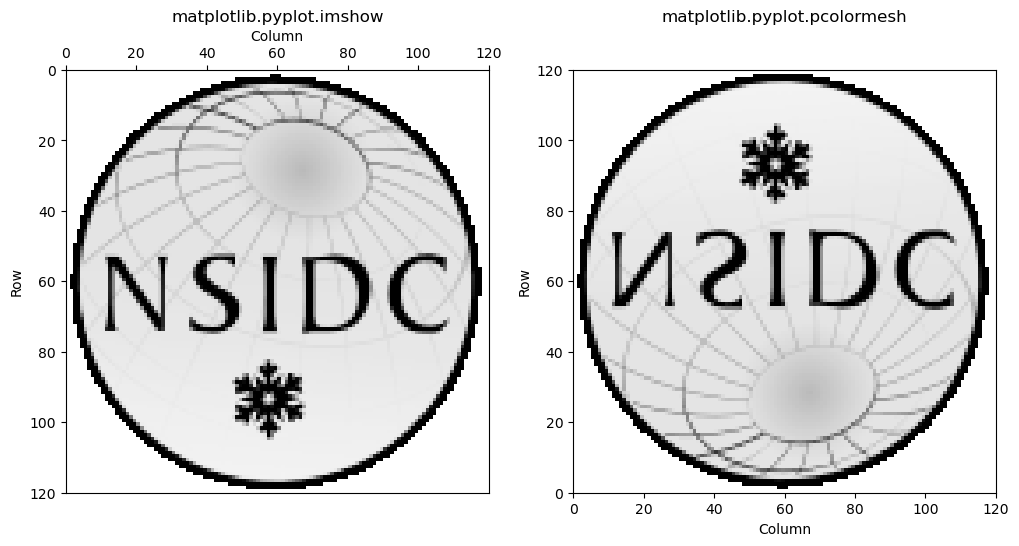

In [189]:
#| label: fig-image-coordinates
#| fig-cap: "NSIDC Logo image plotted using two tools"

fig, ax = plt.subplots(1, 2, figsize=(12,7))

ax[0].imshow(image, extent=[0,120,120,0], cmap="Greys", interpolation="none")
ax[0].xaxis.set_ticks_position("top")
ax[0].xaxis.set_label_position("top")
ax[0].set_xlabel("Column")
ax[0].set_ylabel("Row")
ttl0 = ax[0].set_title("matplotlib.pyplot.imshow")
#print(ttl0.get_position())

ax[1].pcolormesh(image, cmap="Greys")
ax[1].set_aspect(1)
ax[1].set_xlabel("Column")
ax[1].set_ylabel("Row")
ax[1].set_title("matplotlib.pyplot.pcolormesh", pad=35);


## Adding Coordinates to an Image

The row and column coordinates in @fig-image-coordinates can be thought of as the image coordinate system.  However, georeference the image, we need to assign map coordinates to the image.  @fig-coordinate-systems a shows a grid in image coordinates (row and column).  @fig-coordinate-systems b shows the same grid in a spatial or projected coordinate system.

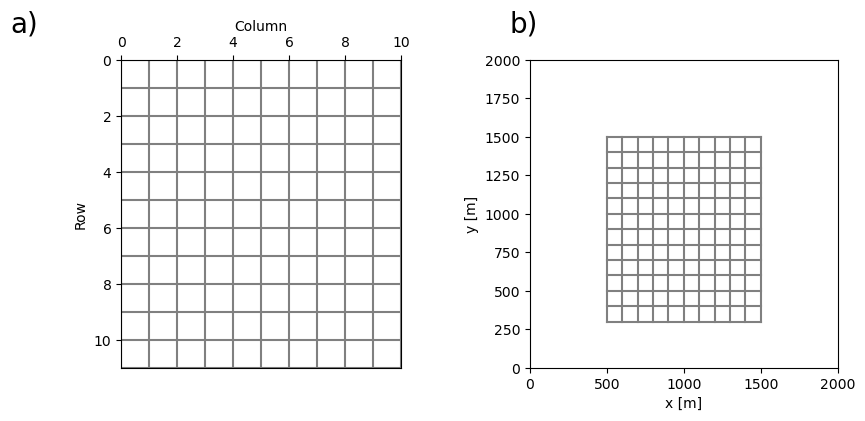

In [190]:
#| label: fig-coordinate-systems
#| fig-cap: "a) An image coordinate system, and b) a spatial coordinate system"

nrow = 12
ncol = 10
r = np.arange(nrow+1)
c = np.arange(ncol+1)

dx = 100.
x0 = 500.
dy = -100.
y0 = 1500.

x = (c * dx) + x0
y = (r * dy) + y0


fig_width= 10
fig_height = 4
fig, ax = plt.subplots(1, 2, figsize=(fig_width,fig_height))

[ax[0].axhline(ri, 0, 1, c='0.5') for ri in r];
[ax[0].axvline(ci, 0, 1, c='0.5') for ci in c];
ax[0].set_xlim(c[0], c[-1])
ax[0].set_xlabel("Column")
ax[0].set_ylim(r[-2], r[0])
ax[0].set_ylabel("Row")
ax[0].xaxis.set_ticks_position("top")
ax[0].xaxis.set_label_position("top")
ax[0].set_aspect(1)

ax[1].set_xlim(0, 2000.)
ax[1].set_ylim(0, 2000.)
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
ax[1].set_aspect(1)
[ax[1].plot([x[i],x[i]], [y[0],y[-1]], c='0.5') for i in np.arange(len(x))];
[ax[1].plot([x[0],x[-1]], [y[j],y[j]], c='0.5') for j in np.arange(len(y))];

fig.text(0.05, 0.95, "a)", fontsize=20);
fig.text(0.55, 0.95, "b)", fontsize=20);

Converting image coordinates to spatial coordinates involves some relatively simple algebra.

$$
\begin{align}
x &= c \Delta x + x_0  \\    
y &= r \Delta y + y_0
\end{align}
$$

where $x$ and $y$ are the spatial coordinates, $c$ and $r$ are image coordinates, $\Delta x$ and $\Delta y$ are the width and height of the pixels in spatial coordinates; and $x_0$ and $y_0$ are the location of the image origin in spatial coordinates.  For this example, $x_0$, $y_0$, $\Delta x$, and $\Delta y$ are:

$$
\begin{align}
x_0 &= 500\,\mathrm{m} \\
y_0 &= 1500\,\mathrm{m} \\
\Delta x &= 100\,\mathrm{m} \\
\Delta y &= -100\,\mathrm{m}
\end{align}
$$

For this example, $\Delta y$ is negative because origin of the column axis is at the top of the image, and the column index increases top-down.  But the origin of the spatial coordinate system is at the lower-left, and increases bottom-up.  

## The Geotransform

The conversion from image to spatial coordinates can also be expressed using Linear Algebra.  Tools like GDAL, use a matrix form of the equations above.

$$
\begin{pmatrix}
\Delta x & 0 & x_0 \\
0 & \Delta y & y0 \\
0 & 0 & 1
\end{pmatrix} \begin{pmatrix} c \\ r \\ 1 \end{pmatrix} = \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}
$$

where the first term on the _left-hand-side_ is the Geotransform.

If an image file includes a Geotransform and software knows what to do with this information, the conversion is done automatically.  If not the `Affine` class from the `affine` python package can be used to calculate $(x, y)$ spatial coordinates from $(c, r)$ image coordinates.

In [27]:
#| code-fold: false
#| echo: true
from affine import Affine

x0 = 500  # x of upper-left corner of upper-left pixel (m)
dx = 100.  # width of pixel in spatial coordinates (m)
y0 = 1500.  # y of upper-left corner of upper-left pixel (m)
dy = -100.  # height of pixel in spatial coordinates (m)
transform = Affine.from_gdal(x0, dx, 0., y0, 0., dy)

transform * (0., 0.)

(500.0, 1500.0)

## Create spatial coordinates for the example image

I'll demonstrate creating spatial coordinates for two 25 km grids: an Original EASE Grid and the NSIDC WGS84 Polar Stereographic Grid.  Remember, at this point we are only converting from image coordinates to spatial coordinates - which is really only scaling the pixels by the height and width in meters, and then translating that scaled grid so that the grid origin (0,0) is at (x,y) in meters.  The grid is independent of the CRS at this point.

We'll do the EASE Grid first.

### Accuracy of EASE Grid parameters

Grid cell size and the coordinates for the upper-left corner of the upper-left pixel for many commonly used EASE Grids are given in the tables on the [A NSIDC Guide to EASE Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids) page.  Unfortunately, the accuracy of these parameters values for the original EASE Grids is not sufficient to reproduce grid coordinates correctly.  This causes problems when grids are concatenated to create data cubes if different parameter values have been used for different grids.

For the 25 km EASE Grid, the [parameter table](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-25-km-resolution-ease-grids) gives the grid cell height and width for EASE Grid as 25067.53 m.  The actual value is 25067.525 m.  To a human and for spatial accuracy 5 mm is not a big deal.  But computers are dumb (and pedantic).  Coordinate-aware geospatial tools used to concatenate grids treat 25067.53 and 25067.525 as difference coordinate values.  This problem occurs with the EASE Grid 2.0 Global and Temperate Zone grids.

::: {.callout-note}
The original EASE Grid cell widths and heights were defined so that a whole number of grid cells spanned the equator in the Global Grid.  This grid cell width and height was then used for the azimuthal projection grids as well.  See the example in Appendix 1 for a demonstration of the impact of this error.
:::


@fig-map-coords shows the NSIDC logo image now in map coordinates and centered on the map origin.  Each pixel now a 25067.525 m by 25067.525 m grid cell.

In [117]:
ncol, nrow = image.shape
dx = 25067.525
dy = -25067.525

grid_origin_x = -1. * dx * ((ncol/2) + 0.5)
grid_origin_y = -1. * dy * ((nrow/2) + 0.5)

# print(grid_origin_x, grid_origin_y)
transform_eg25 = Affine.from_gdal(grid_origin_x, dx, 0, grid_origin_y, 0, dy)

x0 = grid_origin_x
y1 = grid_origin_y
x1, y0 = transform_eg25 * (ncol+1, nrow+1)
extent = [x0, x1, y0, y1]


col = np.arange(ncol) + 0.5
row = np.arange(nrow) + 0.5

x, _ = transform_eg25 * (col, row[0])
_, y = transform_eg25 * (col[0], row)



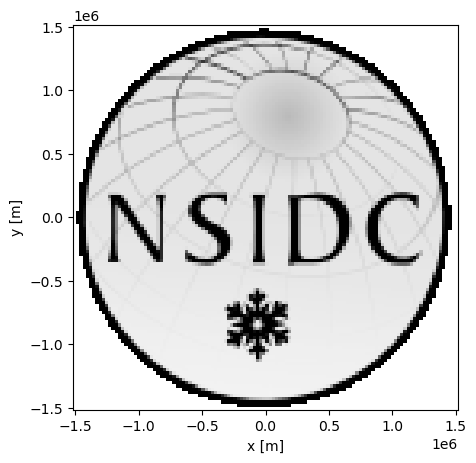

In [143]:
#| label: fig-map-coords
#| fig-cap: "The image in map coordinates"
fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(image, cmap="Greys", extent=extent, interpolation='none')
ax.set_aspect(1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]');

## The Coordinate Reference System

We have the NSIDC logo image in map coordinates but map coordinates on their own do not georeference data.  The map coordinate system has a set of axis and an origin but there is no information about where that origin is on the Earth, or how the axes are oriented.

To georeference the data, you need a coordinate reference system (CRS).  The CRS comprises:

- The Projection method (e.g. Mercator, Lambert Azimuthal Equal Area, Stereographic)
- The Projection parameters
- The Ellipsoid
- The Datum
- The Coordinate System.

@fig-ease-grid shows the NSIDC logo on the NSIDC EASE Grid North CRS (EPSG:3408).  The image is centered on the map coordinate origin (0,0), which coincides with the North Pole.  

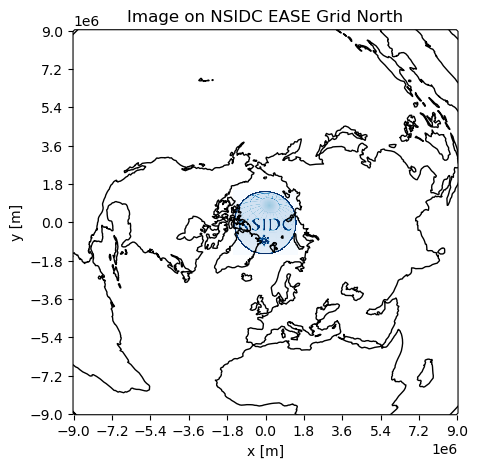

In [147]:
#| label: fig-ease-grid
#| fig-cap: "NSIDC Logo on NSIDC EASE Grid North"
globe = ccrs.Globe(semimajor_axis=6371228., semiminor_axis=6371228)
ease_grid_north = ccrs.LambertAzimuthalEqualArea(central_latitude=90., central_longitude=0,
                                      globe=globe)
map_extent = [-9036842.7625, 9036842.7625, -9036842.7625, 9036842.7625]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection=ease_grid_north)
ax.set_extent(map_extent, ease_grid_north)
ax.coastlines(zorder=3)

ax.set_xticks(np.linspace(-9000000., 9000000., 11), crs=ease_grid_north)
ax.set_yticks(np.linspace(-9000000., 9000000., 11), crs=ease_grid_north)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

ax.imshow(image, cmap="Blues", extent=extent, interpolation='none', 
          transform=ease_grid_north, origin="upper")
ax.set_aspect(1)
ax.set_title("Image on NSIDC EASE Grid North");                 

@fig-ease-grid-shift shows the logo image but now shifted so that the image is centered over Boulder, CO, USA, home of NSIDC.  The boundary of the image is also plotted.

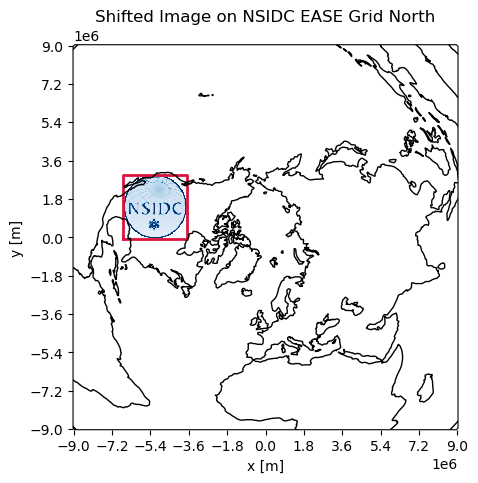

In [186]:
#| label: fig-ease-grid-shift
#| fig-cap: "NSIDC Logo on NSIDC EASE Grid North centered on Boulder, CO"

# Find location of NSIDC in map coordinates
lat_nsidc, lon_nsidc = 40.01250935846803, -105.25280703069157
x_nsidc, y_nsidc = ease_grid_north.transform_point(lon_nsidc, lat_nsidc, ccrs.Geodetic())

# Create a translation matrix
translate = Affine.translation(x_nsidc, y_nsidc)

# Calculate new extent of image centered on NSIDC
new_coords = [translate * extent[i::2] for i in [0,1]]
bounds = list(chain(*new_coords))
new_extent = list(chain(*[bounds[i::2] for i in [0,1]]))

xbnd = [bounds[i] for i in [0,0,2,2,0]]
ybnd = [bounds[j] for j in [1,3,3,1,1]]

globe = ccrs.Globe(semimajor_axis=6371228., semiminor_axis=6371228)
ease_grid_north = ccrs.LambertAzimuthalEqualArea(central_latitude=90., central_longitude=0,
                                      globe=globe)
map_extent = [-9036842.7625, 9036842.7625, -9036842.7625, 9036842.7625]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection=ease_grid_north)
ax.set_extent(map_extent, ease_grid_north)
ax.coastlines(zorder=3)

ax.set_xticks(np.linspace(-9000000., 9000000., 11), crs=ease_grid_north)
ax.set_yticks(np.linspace(-9000000., 9000000., 11), crs=ease_grid_north)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

ax.imshow(image, cmap="Blues", extent=new_extent, interpolation='none', 
          transform=ease_grid_north, origin="upper")
ax.plot(xbnd, ybnd, transform=ease_grid_north, color='crimson', lw=2)

ax.set_aspect(1)
ax.set_title("Shifted Image on NSIDC EASE Grid North");          

To illustrate the independence of the image grid from the CRS, @fig-psnorth shows the NSIDC logo image on the NSIDC WGS84 North Polar Stereographic CRS (EPSG:3413).  In  this CRS, the central longitude is $-45^{\circ} E$.  The y-axis of the map coordinate system is aligned with this line of longitude.  The Prime Meridian and $90^{\circ} E$ and $-90^{\circ} E$ meridians are shown to demonstrate this alignment.  

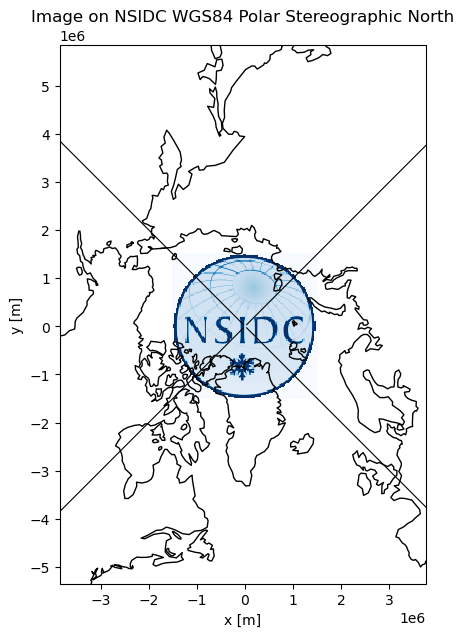

In [187]:
#| label: fig-psnorth
#| fig-cap: "NSIDC logo image on NSIDC WGS84 North Polar Stereographic"
globe = ccrs.Globe()  # Default globe is WGS84
proj = ccrs.Stereographic(central_latitude=90., central_longitude=-45,
                          true_scale_latitude=70., globe=globe)

map_extent = [-3850000, 3750000, -5350000, 5850000]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=proj)
ax.set_extent(map_extent, proj)
ax.coastlines(zorder=3)
ax.gridlines(xlocs=[0,90,180,-90], ylocs=[], draw_labels=True, color='k')

ax.set_xticks(np.linspace(-3000000., 3000000., 7), crs=proj)
ax.set_yticks(np.linspace(-5000000., 5000000., 11), crs=proj)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

ax.imshow(image, cmap="Blues", extent=extent, interpolation='none', 
          transform=proj, origin="upper")
ax.set_aspect(1)
ax.set_title("Image on NSIDC WGS84 Polar Stereographic North");                 

@fig-psnorth-pm is still a North Polar Stereographic projection with a WGS84 ellipsoid but the _central longitude_ is the Greenwich Prime Meridian ($0^{\circ} E$).  The map coordinates of the image have not been changed: the y-axis is still oriented vertically.  But in this CRS, the y-axis is aligned with $0^{\circ} E$.  

::: {.callout-note}
Many geospatial tools use this 

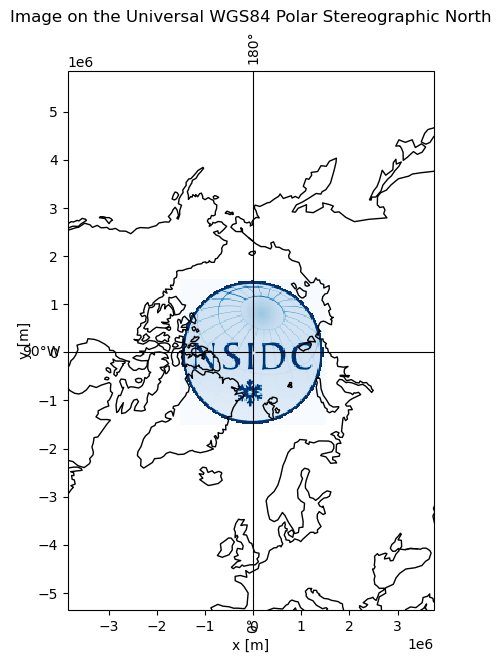

In [191]:
#| label: fig-psnorth-pm
#| fig-cap: "NSIDC logo image on a Universal WGS84 North Polar Stereographic CRS"
globe = ccrs.Globe()  # Default globe is WGS84
proj = ccrs.Stereographic(central_latitude=90., central_longitude=0.,
                          true_scale_latitude=70., globe=globe)

map_extent = [-3850000, 3750000, -5350000, 5850000]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=proj)
ax.set_extent(map_extent, proj)
ax.coastlines(zorder=3)
ax.gridlines(xlocs=[0,90,180,-90], ylocs=[], draw_labels=True, color='k')

ax.set_xticks(np.linspace(-3000000., 3000000., 7), crs=proj)
ax.set_yticks(np.linspace(-5000000., 5000000., 11), crs=proj)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

ax.imshow(image, cmap="Blues", extent=extent, interpolation='none', 
          transform=proj, origin="upper")
ax.set_aspect(1)
ax.set_title("Image on the Universal WGS84 Polar Stereographic North");

## Representing Spatial Coordinates in GeoTIFF and NetCDF

## References
[GDAL Raster data model](https://gdal.org/user/raster_data_model.html)  
[NSIDC Guide to Polar Stereographic](https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection)  
[NSIDC Guide to EASE Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids)  

## Appendix 1

This appendix shows how the correct grid cell height and width and grid origin in map coordinates.

The grid parameters and coordinate reference systems for most NSIDC grids can be found in [the `mapxmaps` Github repository](https://github.com/nsidc/mapxmaps).  Definitions are in _grid parameter definition_ (GPD) (`.gpd`) files.  The GPD file for the EASE Grid North 25 km grid is `Nl.gpd`

```
N200correct.mpp	map projection parameters		# EASE-Grid
721 721		columns rows				# Northern Hemisphere
8		grid cells per map unit			# 25 km
360.0 360.0	map origin column,row			#
```

The map projection parameter file `N200correct.mpp` is
```
Azimuthal Equal-Area
90.0	0.0	lat0 lon0
0.0		rotation
200.5402	scale (km/map unit)
90.00	00.00	center lat lon
0.00   90.00	lat min max
-180.00  180.00	lon min max
15.00 30.00	grid
0.00	00.00	label lat lon
1 0 0		cil bdy riv
```

The key information to calculate grid cell height ($\Delta y$) and width ($\Delta x$), and the grid map origin $(x_0, y_0)$ are the shape of the grid in _columns_ and _rows_ (721 columns and 721 rows), the _grid cells per map unit_, the _map origin column and row_, and the _scale (km/map unit)_ in the `N200correct.mpp` file.

$\Delta x$ and $\Delta y$ are found by dividing _scale_ by _grid cells per map unit_.

In [75]:
#| code-fold: false
#| echo: true
map_scale = 200.5402e3  # EASE Grid map-scale parameter km/map-unit from N200correct.mpp
grid_cells_per_map_unit = 8  # grid cells per map unit from Nl.gpd

cell_width = map_scale / grid_cells_per_map_unit
cell_height = -cell_width
print(f"cell_width: {cell_width} m, cell_height: {cell_height} m")

cell_width: 25067.525 m, cell_height: -25067.525 m


_map origin column, row_ gives the column and row coordinates of the map origin.  For EASE Grid North, this is $90^{\circ}\,N$, $0^{\circ}\,W$, from `lat0` and `lon0` in `N200correct.mpp`.  $x_0$ and $y_0$ are given by:

$$
\begin{align}
x_0 &= -1 \times \Delta x \times (\mathit{map\_origin\_column} + 0.5) \\
y_0 &= -1 \times \Delta y \times (\mathit{map\_origin\_row} + 0.5)
\end{align}
$$

The addition of 0.5 is because the original EASE grid definitions have the grid origin (0,0) at the center of the upper-left pixel, not the upper-left corner of the upper-left pixel. 

In [77]:
#| code-fold: false
#| echo: true
map_origin_column = 360
map_origin_row = 360
x0 = -1 * cell_width * (map_origin_column + 0.5)
y0 = -1 * cell_height * (map_origin_row + 0.5)
print(f"grid_origin_x: {x0} m")
print(f"grid_origin_y: {y0} m")

grid_origin_x: -9036842.762500001 m
grid_origin_y: 9036842.762500001 m


So to fully define the Grid parameters, the $x$ and $y$ coordinates of the grid origin need to be given to 4 decimal places.  Not 2 as in the tables.

To demonstrate why this is a problem, I define to `xarray` datasets; `ds1` and `ds2`.  These dummy datasets are supposed to cover the same region.  They have the same dimensions but one has coordinates defined using a cell width and height of 25067.53 m, and one has a cell width and height of 25067.525 m.  

In [69]:
#| echo: true
#| code-fold: false
nx = 3
ny = 4
dx = dy = 25067.53
ds1 = xr.Dataset(
    {
        'data': (('y', 'x'), np.arange(ny*nx).reshape(ny,nx)),
        },
    coords={
        'x': np.arange(nx)*dx,
        'y': np.arange(ny)*dy
    }
)
ds1

<xarray.Dataset> Size: 152B
Dimensions:  (y: 4, x: 3)
Coordinates:
  * x        (x) float64 24B 0.0 2.507e+04 5.014e+04
  * y        (y) float64 32B 0.0 2.507e+04 5.014e+04 7.52e+04
Data variables:
    data     (y, x) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11

In [70]:
#| echo: true
#| code-fold: false
dx = dy = 25067.525
ds2 = xr.Dataset(
    {
        'data': (('y', 'x'), (np.arange(ny*nx)+10).reshape(ny,nx)),
    },
    coords={
        'x': np.arange(nx)*dx,
        'y': np.arange(ny)*dy
        },
    )
ds2

<xarray.Dataset> Size: 152B
Dimensions:  (y: 4, x: 3)
Coordinates:
  * x        (x) float64 24B 0.0 2.507e+04 5.014e+04
  * y        (y) float64 32B 0.0 2.507e+04 5.014e+04 7.52e+04
Data variables:
    data     (y, x) int64 96B 10 11 12 13 14 15 16 17 18 19 20 21

A common workflow is to load these datasets using `xarray` to create a data cube with dimensions `(x, y, time)`.  This could be done using `xarray.open_mfdataset` or `xarray.concat`.  We would expect to get a data cube with the same `x` and `y` dimensions and a new `time` dimension.

In [71]:
#| echo: true
#| code-fold: false
dscat = xr.concat([ds1,ds2], "time")
dscat

<xarray.Dataset> Size: 656B
Dimensions:  (x: 5, y: 7, time: 2)
Coordinates:
  * x        (x) float64 40B 0.0 2.507e+04 2.507e+04 5.014e+04 5.014e+04
  * y        (y) float64 56B 0.0 2.507e+04 2.507e+04 ... 7.52e+04 7.52e+04
Dimensions without coordinates: time
Data variables:
    data     (time, y, x) float64 560B 0.0 nan 1.0 nan 2.0 ... nan nan nan nan

However, instead of a datacube with dimensions `(x: 3, y: 4, time:2)` we get dimensions `(x: 5, y: 7, time: 2)`.  Taking a looking at the `x` and `y` values, we can see that the `x` and `y` coordinates have "duplicates" off by a few mm (e.g. 25067.525 and 25067.53).  This is because `xarray` sees that the two values are different and treats them as unique coordinates.